# Predicting Runs Scored: Data Wrangling

Last lesson we decided to switch our focus onto predicting runs scored. 

This could be useful in several capacities:
- For predicting the over/under
- To create features for predicting the game winner

We will focus on predicting the distribution of runs scored - that is, putting a probability on each possible value of runs scored for a team (up to some maximum value)
Predicting the distribution of a numeric target variable is known as "probabilistic regression"
In this notebook, we will "wrangle" our data such that each row represents a hitting team against a pitching team
The goal will be to predict the (distribution of the) number of runs scored by the hitting team

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_columns',1000)
pd.set_option('display.max_rows',1000)

In [2]:
df=pd.read_csv('Data/df_bp9.csv')

/tmp/ipykernel_116338/623349023.py:1: DtypeWarning: Columns (13,14,15,19,85,87,159,198) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('Data/df_bp9.csv')


# Want to "split" each game into two rows:
- One where the home team bats against the visiting pitchers (and we try to predict the runs of the home team)
- Other where we switch the roles of home and visiting

Then we can model how many runs we expect based on the hitters for that team and the opposing pitching

In [3]:
cols_ref = ['season', 'date','dblheader_code','date_dblhead','team_h','team_v',
            'league_h','league_v','over_under_line','over_under_result',
           'ballpark_id', 'day_night']
target_cols = ['runs_h', 'runs_v']

In [4]:
team_hit_stems = ['BATAVG','OBP','SLG','OBS','ERR','SB','CS']
lineup_hit_stems = ['BATAVG','OBP','SLG','OBS','SLGmod','SObat_perc']
strt_pitch_stems = ['ERA','WHIP','SO_perc','H_BB_perc','TB_BB_perc','FIP','FIP_perc']
bpen_pitch_stems = ['WHIP','SO_perc','H_BB_perc','TB_BB_perc']

team_hit_winsizes = [30,162]
lineup_hit_winsizes = [30,75,162,350]
strt_pitch_winsizes = [10,35,75]
bpen_pitch_winsizes = [10,35,75]

In [5]:
# We will make two data frames:
# version 'a': home hitting and visitor pitching


team_hit_features_a = [x+'_'+str(winsize)+'_h' for winsize in team_hit_winsizes for x in team_hit_stems ]
lineup_hit_features_a = ['lineup'+n89+'_'+x+'_'+str(winsize)+wornot+'_h' for winsize in lineup_hit_winsizes
                        for x in lineup_hit_stems for wornot in ['','_w'] for n89 in ['8','9']]
start_pitch_features_a = ['Strt_'+x+'_'+str(winsize)+'_v' for winsize in strt_pitch_winsizes for x in strt_pitch_stems]
bpen_pitch_features_a = ['Bpen_'+x+'_'+str(winsize)+'_v' for winsize in bpen_pitch_winsizes for x in bpen_pitch_stems]

# version 'b': visit hitting and home pitching

team_hit_features_b = [x+'_'+str(winsize)+'_v' for winsize in team_hit_winsizes for x in team_hit_stems ]
lineup_hit_features_b = ['lineup'+n89+'_'+x+'_'+str(winsize)+wornot+'_v' for winsize in lineup_hit_winsizes
                        for x in lineup_hit_stems for wornot in ['','_w'] for n89 in ['8','9']]
start_pitch_features_b = ['Strt_'+x+'_'+str(winsize)+'_h' for winsize in strt_pitch_winsizes for x in strt_pitch_stems]
bpen_pitch_features_b = ['Bpen_'+x+'_'+str(winsize)+'_h' for winsize in bpen_pitch_winsizes for x in bpen_pitch_stems]


In [6]:
cols_a = cols_ref + ['runs_h'] + team_hit_features_a + lineup_hit_features_a + start_pitch_features_a + bpen_pitch_features_a
df_a = df.loc[:,cols_a]
df_a['home_hitting'] = 1


cols_b = cols_ref + ['runs_v'] + team_hit_features_b + lineup_hit_features_b + start_pitch_features_b + bpen_pitch_features_b
df_b = df.loc[:,cols_b]
df_b['home_hitting'] = 0

stripped_feats  = [x[:-2] for x in team_hit_features_a + lineup_hit_features_a + 
                                              start_pitch_features_a + bpen_pitch_features_a]

final_col_list = cols_ref +['runs'] + stripped_feats+ ['home_hitting']

df_a.columns = final_col_list
df_b.columns = final_col_list
df_runs = pd.concat((df_a,df_b))

In [7]:
df_runs.sample(5)

,season,date,dblheader_code,date_dblhead,team_h,team_v,league_h,league_v,over_under_line,over_under_result,ballpark_id,day_night,runs,BATAVG_30,OBP_30,SLG_30,OBS_30,ERR_30,SB_30,CS_30,BATAVG_162,OBP_162,SLG_162,OBS_162,ERR_162,SB_162,CS_162,lineup8_BATAVG_30,lineup9_BATAVG_30,lineup8_BATAVG_30_w,lineup9_BATAVG_30_w,lineup8_OBP_30,lineup9_OBP_30,lineup8_OBP_30_w,lineup9_OBP_30_w,lineup8_SLG_30,lineup9_SLG_30,lineup8_SLG_30_w,lineup9_SLG_30_w,lineup8_OBS_30,lineup9_OBS_30,lineup8_OBS_30_w,lineup9_OBS_30_w,lineup8_SLGmod_30,lineup9_SLGmod_30,lineup8_SLGmod_30_w,lineup9_SLGmod_30_w,lineup8_SObat_perc_30,lineup9_SObat_perc_30,lineup8_SObat_perc_30_w,lineup9_SObat_perc_30_w,lineup8_BATAVG_75,lineup9_BATAVG_75,lineup8_BATAVG_75_w,lineup9_BATAVG_75_w,lineup8_OBP_75,lineup9_OBP_75,lineup8_OBP_75_w,lineup9_OBP_75_w,lineup8_SLG_75,lineup9_SLG_75,lineup8_SLG_75_w,lineup9_SLG_75_w,lineup8_OBS_75,lineup9_OBS_75,lineup8_OBS_75_w,lineup9_OBS_75_w,lineup8_SLGmod_75,lineup9_SLGmod_75,lineup8_SLGmod_75_w,lineup9_SLGmod_75_w,lineup8_SObat_perc_75,lineup9_SObat_perc_75,lineup8_SObat_perc_75_w,lineup9_SObat_perc_75_w,lineup8_BATAVG_162,lineup9_BATAVG_162,lineup8_BATAVG_162_w,lineup9_BATAVG_162_w,lineup8_OBP_162,lineup9_OBP_162,lineup8_OBP_162_w,lineup9_OBP_162_w,lineup8_SLG_162,lineup9_SLG_162,lineup8_SLG_162_w,lineup9_SLG_162_w,lineup8_OBS_162,lineup9_OBS_162,lineup8_OBS_162_w,lineup9_OBS_162_w,lineup8_SLGmod_162,lineup9_SLGmod_162,lineup8_SLGmod_162_w,lineup9_SLGmod_162_w,lineup8_SObat_perc_162,lineup9_SObat_perc_162,lineup8_SObat_perc_162_w,lineup9_SObat_perc_162_w,lineup8_BATAVG_350,lineup9_BATAVG_350,lineup8_BATAVG_350_w,lineup9_BATAVG_350_w,lineup8_OBP_350,lineup9_OBP_350,lineup8_OBP_350_w,lineup9_OBP_350_w,lineup8_SLG_350,lineup9_SLG_350,lineup8_SLG_350_w,lineup9_SLG_350_w,lineup8_OBS_350,lineup9_OBS_350,lineup8_OBS_350_w,lineup9_OBS_350_w,lineup8_SLGmod_350,lineup9_SLGmod_350,lineup8_SLGmod_350_w,lineup9_SLGmod_350_w,lineup8_SObat_perc_350,lineup9_SObat_perc_350,lineup8_SObat_perc_350_w,lineup9_SObat_perc_350_w,Strt_ERA_10,Strt_WHIP_10,Strt_SO_perc_10,Strt_H_BB_perc_10,Strt_TB_BB_perc_10,Strt_FIP_10,Strt_FIP_perc_10,Strt_ERA_35,Strt_WHIP_35,Strt_SO_perc_35,Strt_H_BB_perc_35,Strt_TB_BB_perc_35,Strt_FIP_35,Strt_FIP_perc_35,Strt_ERA_75,Strt_WHIP_75,Strt_SO_perc_75,Strt_H_BB_perc_75,Strt_TB_BB_perc_75,Strt_FIP_75,Strt_FIP_perc_75,Bpen_WHIP_10,Bpen_SO_perc_10,Bpen_H_BB_perc_10,Bpen_TB_BB_perc_10,Bpen_WHIP_35,Bpen_SO_perc_35,Bpen_H_BB_perc_35,Bpen_TB_BB_perc_35,Bpen_WHIP_75,Bpen_SO_perc_75,Bpen_H_BB_perc_75,Bpen_TB_BB_perc_75,home_hitting
67346,2010,20100628,0,201006280,SDN,COL,NL,NL,0.0,NaN,SAN02,N,6,0.248538,0.301630,0.371345,0.672975,9.0,14.0,11.0,0.246658,0.317405,0.374657,0.692062,87.0,118.0,43.0,0.253000,0.236000,0.253738,0.238827,0.318949,0.300177,0.319639,0.303185,0.396783,0.363807,0.396840,0.368048,0.715732,0.663984,0.716479,0.671233,0.380588,0.380893,0.377010,0.377624,0.161676,0.180749,0.158720,0.175657,0.252616,0.234918,0.253103,0.237606,0.324659,0.302660,0.325719,0.306412,0.390059,0.357830,0.390155,0.362012,0.714719,0.660491,0.715875,0.668424,0.401798,0.391228,0.399024,0.390066,0.181749,0.191185,0.178626,0.187165,0.258385,0.235162,0.258938,0.238612,0.331059,0.301820,0.332035,0.306415,0.396818,0.358557,0.396415,0.363054,0.727878,0.660377,0.728450,0.669469,0.401013,0.376003,0.398191,0.376632,0.178647,0.175944,0.176162,0.174043,0.252040,0.227210,0.252974,0.231209,0.330503,0.298543,0.331600,0.303593,0.395305,0.354875,0.395302,0.360008,0.725809,0.653417,0.726901,0.663601,0.413738,0.379831,0.411425,0.382050,0.183318,0.173108,0.181443,0.172712,1.981651,1.032110,0.227758,0.266904,0.377224,2.050459,0.530249,2.488308,1.093535,0.230690,0.272915,0.361483,2.182944,0.544799,3.106195,1.221239,0.215764,0.294581,0.381281,2.565010,0.618719,1.675325,0.157895,0.377193,0.596491,1.251880,0.194366,0.312676,0.470423,1.248074,0.202561,0.314319,0.440047,1
48753,2002,20020828,0,200208280,COL,SFN,NL,NL,0.0,NaN,DEN02,N,9,0.263003,0.327061,0.448479,0.775540,16.0,1

In [8]:
df_runs.to_csv('Data/df_runs_bp11.csv', index=False)

# Predicting Runs Scored - The First Model

We will now use the data frame from before to build a model to predict the distribution of runs scored.

We will use an algorithm called Coarsage to model these distributions (Coarsage is in the StructureBoost package)
- Coarsage is similar to PrestoBoost (a paper on PrestoBoost can be found here: https://arxiv.org/abs/2210.16247)
- But it is a bit cleaner (needs only a single forest)

In [9]:
import structureboost as stb
import ml_insights as mli


In [10]:
stb.__version__

'0.4.3'

In [11]:
df=pd.read_csv('Data/df_bp9.csv')
df_runs=pd.read_csv('Data/df_runs_bp11.csv')

/tmp/ipykernel_116338/145339343.py:1: DtypeWarning: Columns (13,14,15,19,85,87,159,198) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('Data/df_bp9.csv')
/tmp/ipykernel_116338/145339343.py:2: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df_runs=pd.read_csv('Data/df_runs_bp11.csv')


In [12]:
df.over_under_line.max()

15.0

In [13]:
df_runs['runs_trunc'] = np.minimum(df_runs['runs'],15)

In [14]:
df_train = df_runs[(df_runs.season>1980) & (df_runs.season<=2018) & ~(df_runs.OBP_162.isnull())]
df_valid = df_runs[(df_runs.season>=2019) & (df_runs.season<=2020)]
df_test = df_runs[df_runs.season>=2021]

In [15]:
df_test_game = df[df.season>=2021]

In [16]:
df_runs.head()

,season,date,dblheader_code,date_dblhead,team_h,team_v,league_h,league_v,over_under_line,over_under_result,ballpark_id,day_night,runs,BATAVG_30,OBP_30,SLG_30,OBS_30,ERR_30,SB_30,CS_30,BATAVG_162,OBP_162,SLG_162,OBS_162,ERR_162,SB_162,CS_162,lineup8_BATAVG_30,lineup9_BATAVG_30,lineup8_BATAVG_30_w,lineup9_BATAVG_30_w,lineup8_OBP_30,lineup9_OBP_30,lineup8_OBP_30_w,lineup9_OBP_30_w,lineup8_SLG_30,lineup9_SLG_30,lineup8_SLG_30_w,lineup9_SLG_30_w,lineup8_OBS_30,lineup9_OBS_30,lineup8_OBS_30_w,lineup9_OBS_30_w,lineup8_SLGmod_30,lineup9_SLGmod_30,lineup8_SLGmod_30_w,lineup9_SLGmod_30_w,lineup8_SObat_perc_30,lineup9_SObat_perc_30,lineup8_SObat_perc_30_w,lineup9_SObat_perc_30_w,lineup8_BATAVG_75,lineup9_BATAVG_75,lineup8_BATAVG_75_w,lineup9_BATAVG_75_w,lineup8_OBP_75,lineup9_OBP_75,lineup8_OBP_75_w,lineup9_OBP_75_w,lineup8_SLG_75,lineup9_SLG_75,lineup8_SLG_75_w,lineup9_SLG_75_w,lineup8_OBS_75,lineup9_OBS_75,lineup8_OBS_75_w,lineup9_OBS_75_w,lineup8_SLGmod_75,lineup9_SLGmod_75,lineup8_SLGmod_75_w,lineup9_SLGmod_75_w,lineup8_SObat_perc_75,lineup9_SObat_perc_75,lineup8_SObat_perc_75_w,lineup9_SObat_perc_75_w,lineup8_BATAVG_162,lineup9_BATAVG_162,lineup8_BATAVG_162_w,lineup9_BATAVG_162_w,lineup8_OBP_162,lineup9_OBP_162,lineup8_OBP_162_w,lineup9_OBP_162_w,lineup8_SLG_162,lineup9_SLG_162,lineup8_SLG_162_w,lineup9_SLG_162_w,lineup8_OBS_162,lineup9_OBS_162,lineup8_OBS_162_w,lineup9_OBS_162_w,lineup8_SLGmod_162,lineup9_SLGmod_162,lineup8_SLGmod_162_w,lineup9_SLGmod_162_w,lineup8_SObat_perc_162,lineup9_SObat_perc_162,lineup8_SObat_perc_162_w,lineup9_SObat_perc_162_w,lineup8_BATAVG_350,lineup9_BATAVG_350,lineup8_BATAVG_350_w,lineup9_BATAVG_350_w,lineup8_OBP_350,lineup9_OBP_350,lineup8_OBP_350_w,lineup9_OBP_350_w,lineup8_SLG_350,lineup9_SLG_350,lineup8_SLG_350_w,lineup9_SLG_350_w,lineup8_OBS_350,lineup9_OBS_350,lineup8_OBS_350_w,lineup9_OBS_350_w,lineup8_SLGmod_350,lineup9_SLGmod_350,lineup8_SLGmod_350_w,lineup9_SLGmod_350_w,lineup8_SObat_perc_350,lineup9_SObat_perc_350,lineup8_SObat_perc_350_w,lineup9_SObat_perc_350_w,Strt_ERA_10,Strt_WHIP_10,Strt_SO_perc_10,Strt_H_BB_perc_10,Strt_TB_BB_perc_10,Strt_FIP_10,Strt_FIP_perc_10,Strt_ERA_35,Strt_WHIP_35,Strt_SO_perc_35,Strt_H_BB_perc_35,Strt_TB_BB_perc_35,Strt_FIP_35,Strt_FIP_perc_35,Strt_ERA_75,Strt_WHIP_75,Strt_SO_perc_75,Strt_H_BB_perc_75,Strt_TB_BB_perc_75,Strt_FIP_75,Strt_FIP_perc_75,Bpen_WHIP_10,Bpen_SO_perc_10,Bpen_H_BB_perc_10,Bpen_TB_BB_perc_10,Bpen_WHIP_35,Bpen_SO_perc_35,Bpen_H_BB_perc_35,Bpen_TB_BB_perc_35,Bpen_WHIP_75,Bpen_SO_perc_75,Bpen_H_BB_perc_75,Bpen_TB_BB_perc_75,home_hitting,runs_trunc
0,1980,19800409,0,198004090,SEA,TOR,AL,AL,0.0,NaN,SEA02,N,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.258957,0.244999,0.261081,0.248690,0.316389,0.299753,0.318195,0.303498,0.391599,0.366607,0.393452,0.371455,0.707988,0.666360,0.711647,0.674953,0.302610,0.283802,0.301660,0.285333,0.103902,0.099765,0.103370,0.099810,0.247605,0.241513,0.247225,0.241943,0.302829,0.293223,0.301952,0.293652,0.357380,0.344445,0.356761,0.345529,0.660209,0.637667,0.658713,0.639181,0.277352,0.272526,0.275707,0.271654,0.101148,0.107454,0.100206,0.105801,0.236959,0.232164,0.235594,0.231540,0.293375,0.284567,0.291567,0.284053,0.341385,0.330441,0.339080,0.329750,0.634760,0.615009,0.630646,0.613803,0.271778,0.267889,0.269267,0.266116,0.101146,0.108100,0.099922,0.106111,0.207199,0.203860,0.206608,0.203750,0.259931,0.254701,0.258950,0.254479,0.296881,0.288656,0.295494,0.288449,0.556812,0.543357,0.554444,0.542928,0.243524,0.242021,0.241553,0.240432,0.092185,0.098451,0.091244,0.096804,5.692771,1.572289,0.104418,0.349398,0.502008,5.186747,1.152610,3.857143,1.357945,0.115165,0.321551,0.434436,4.040128,0.956670,4.644315,1.460641,0.098187,0.336354,0.459215,4.723032,1.087613,1.5,0.2,0.37,0.45,1.5,0.2,0.37,0.45,1.5,0.2,0.37,0.45,1,8
1,1980,19800409,0,198004090,CIN,ATL,NL,NL,0.0,NaN,CIN08,D,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.291169,0.266224,0.291499,0.269692,0.358840,0.326376,0.359266,0.330886,0.443534,

In [17]:
feat_set = ['OBP_162',
 'SLG_162',
 'Strt_WHIP_35',
 'Strt_TB_BB_perc_35',
 'Strt_H_BB_perc_35',
 'Strt_SO_perc_10',
 'Bpen_WHIP_75',
 'Bpen_TB_BB_perc_75',
 'Bpen_H_BB_perc_75',
 'Bpen_SO_perc_75',
 'Bpen_WHIP_35',
 'Bpen_TB_BB_perc_35',
 'Bpen_H_BB_perc_35',
 'Bpen_SO_perc_35',
 'Bpen_WHIP_10',
 'Bpen_TB_BB_perc_10',
 'Bpen_H_BB_perc_10',
 'Bpen_SO_perc_10',
 'lineup9_OBP_162',
 'lineup9_SLG_162',
 'home_hitting']


In [18]:
bpv2 = np.linspace(-.5,15.5,17)
bpv2

array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5,
       10.5, 11.5, 12.5, 13.5, 14.5, 15.5])

In [19]:
# def try_features_runs(feat_set, max_depth=2):
target = 'runs_trunc'
X_train = df_train.loc[:,feat_set]
X_valid = df_valid.loc[:,feat_set]
X_test = df_test.loc[:,feat_set]

y_train = df_train[target].to_numpy()
y_valid = df_valid[target].to_numpy()
y_test = df_test[target].to_numpy()

In [20]:
cr1 = stb.Coarsage(num_trees = 1000, learning_rate=.02, max_depth=4,
                  binpt_method = 'fixed', 
               binpt_vec=bpv2)
cr1.fit(X_train, y_train, eval_set=(X_valid, y_valid), early_stop_past_steps=5, eval_freq=10)

i=0, eval_set_loss = 2.4923488860022043
i=10, eval_set_loss = 2.4890844431947667
i=20, eval_set_loss = 2.4863617334073105
i=30, eval_set_loss = 2.484514541229418
i=40, eval_set_loss = 2.483225276058545
i=50, eval_set_loss = 2.482249875309858
i=60, eval_set_loss = 2.481555398356541
i=70, eval_set_loss = 2.4808501713364963
i=80, eval_set_loss = 2.480231173676746
i=90, eval_set_loss = 2.479512222041546
i=100, eval_set_loss = 2.478850470668549
i=110, eval_set_loss = 2.4785766830711924
i=120, eval_set_loss = 2.478311514007307
i=130, eval_set_loss = 2.4780619289887174
i=140, eval_set_loss = 2.477788632735102
i=150, eval_set_loss = 2.4777655744318605
i=160, eval_set_loss = 2.4776310366185914
i=170, eval_set_loss = 2.477638294811124
i=180, eval_set_loss = 2.4775425959243065
i=190, eval_set_loss = 2.47747791051893
i=200, eval_set_loss = 2.477453368954203
i=210, eval_set_loss = 2.4775210302808865
i=220, eval_set_loss = 2.4774388787948407
i=230, eval_set_loss = 2.47742249073046
i=240, eval_set_lo

In [21]:
preds_test = cr1.predict_distributions(X_test)
preds_test.log_loss(y_test)

2.4209394652333804

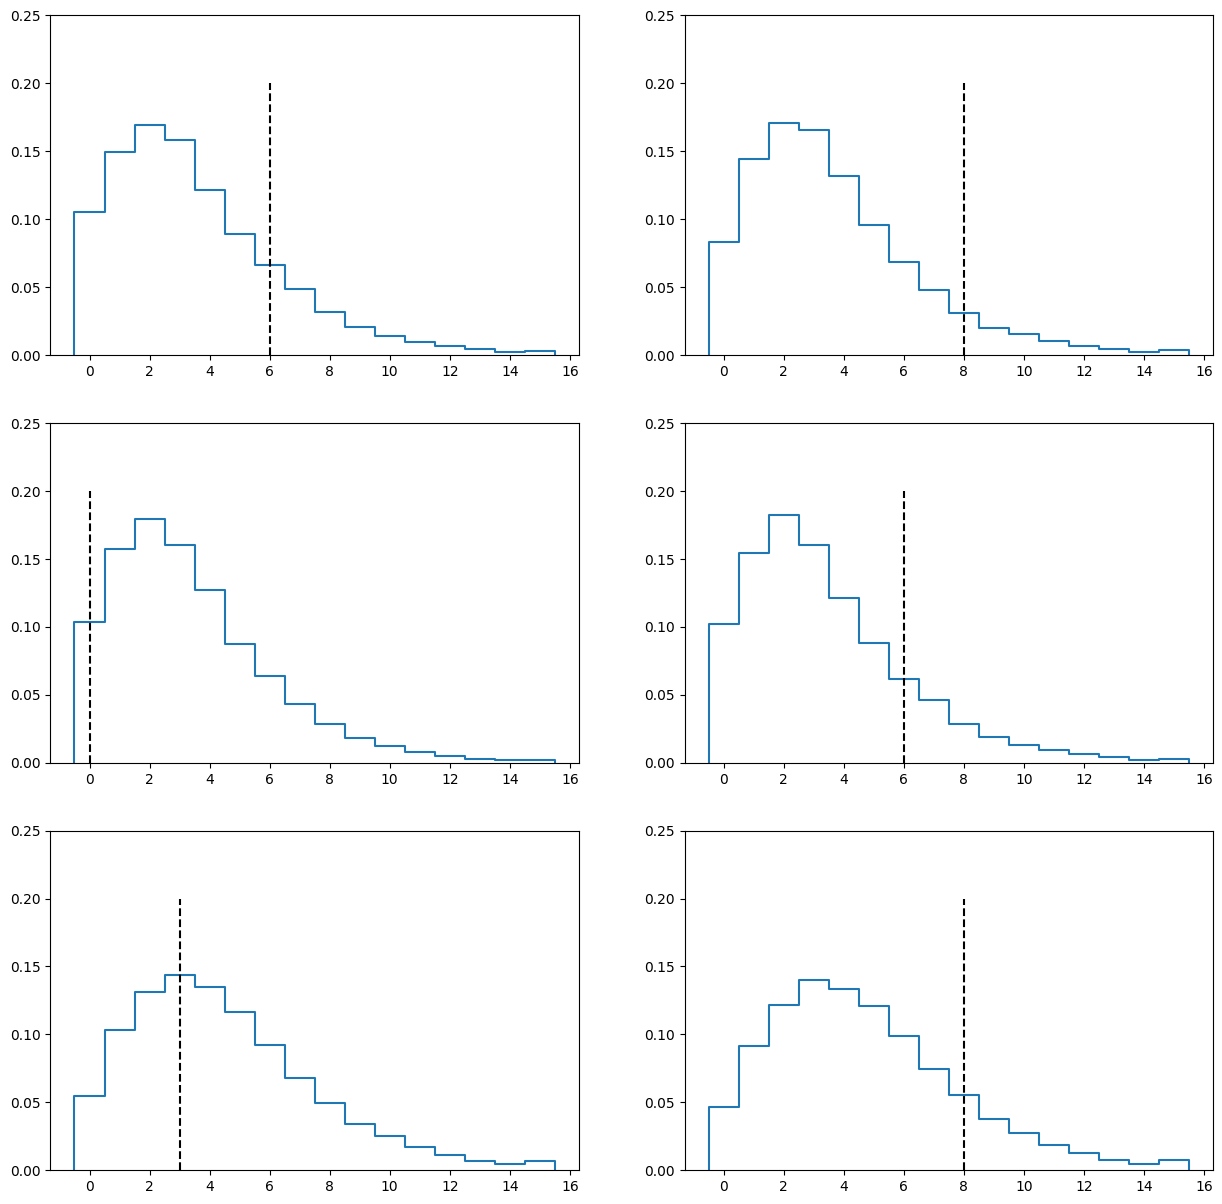

In [22]:
plt.figure(figsize=(15,15))
for i in range(1,7):
    plt.subplot(3,2,i)
    preds_test[i].plot_density()
    plt.ylim([0,.25])
    plt.vlines(x=y_test[i], ymin=0,ymax=.2, color='k', linestyle='--')

# Next Steps
- Using these probability distributions, we can now predict the distribution of total number of runs scored (by adding together the two distributions)
- Using that, we can come up with probabilities on whether the total number of runs exceeds the over/under line